In [2]:
from imblearn.over_sampling import SMOTE


In [1]:
import pickle

with open('../model/data/paradeigma_ts_data_preprocessing.pkl', 'rb') as f:
    target_data_frames = pickle.load(f)

In [2]:
import pandas as pd

num_sessions = 40

target_df = pd.DataFrame(columns=['segment_id', 'emotion', 'valence', 'arousal', 'eda', 'temp', 'ibi'])

for session in range(num_sessions):
    target_df = target_df.append(target_data_frames[session+1], ignore_index=True)

/tmp/ipykernel_2135767/322336854.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_df = target_df.append(target_data_frames[session+1], ignore_index=True)


In [3]:
from glob import glob
annot_lst = glob('../org_KEMDy20/annotation/*.csv')
emotion_list = []
for annot_file in annot_lst:
    annot = pd.read_csv(annot_file, skiprows=1)
    emotion_list.append(annot['Emotion'])
emotion_list = list(pd.Series([j for i in emotion_list for j in i]).unique())
len(emotion_list)

24

In [4]:
# emotion target에 대한 정수 인코딩, 디코딩

encode_dict = {b:i for i, b in enumerate(emotion_list)}
decode_dict = {i:b for i, b in enumerate(emotion_list)}
encode_dict, decode_dict

({'happy': 0,
  'neutral': 1,
  'surprise': 2,
  'surprise;neutral': 3,
  'sad': 4,
  'neutral;sad': 5,
  'happy;neutral': 6,
  'angry;neutral': 7,
  'neutral;disqust': 8,
  'angry': 9,
  'fear': 10,
  'neutral;fear': 11,
  'disqust': 12,
  'happy;surprise': 13,
  'happy;angry;neutral': 14,
  'angry;disqust': 15,
  'happy;surprise;neutral': 16,
  'happy;fear': 17,
  'happy;neutral;fear': 18,
  'angry;neutral;disqust': 19,
  'neutral;disqust;sad': 20,
  'angry;neutral;disqust;fear;sad': 21,
  'happy;sad': 22,
  'happy;neutral;disqust': 23},
 {0: 'happy',
  1: 'neutral',
  2: 'surprise',
  3: 'surprise;neutral',
  4: 'sad',
  5: 'neutral;sad',
  6: 'happy;neutral',
  7: 'angry;neutral',
  8: 'neutral;disqust',
  9: 'angry',
  10: 'fear',
  11: 'neutral;fear',
  12: 'disqust',
  13: 'happy;surprise',
  14: 'happy;angry;neutral',
  15: 'angry;disqust',
  16: 'happy;surprise;neutral',
  17: 'happy;fear',
  18: 'happy;neutral;fear',
  19: 'angry;neutral;disqust',
  20: 'neutral;disqust;sad',

In [5]:
several_target_index = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
several_target_counter = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}

for i in range(len(target_df['emotion'])):
    several_target_index[target_df['emotion'][i].count(';') + 1].append(i)
    several_target_counter[target_df['emotion'][i].count(';') + 1]+= 1

In [6]:
from collections import Counter

count = Counter(target_df['emotion'][several_target_index[1]])

(전체 자료 수 - 감정수) / 전체 자료 수 

temp / eda : 노말 -> 패딩(50,1) (50,1) -> (concat) (50,2) -> conv1d(2, 1, stride = 3, kernelsize = 8)  -> (10,1) -> 텐서퓨전


temp : 노말 -> 패딩(50,1) -> conv1d(1, 1, stride = 3, kernel_size = 8) -> (10,1) -> 텐서퓨전 with wave, text -> 3차원 텐서
eda  : 노말 -> 패딩(50,1) -> conv1d(1, 1, stride = 3, kernel_size = 8) -> (10,1) -> 텐서퓨전 with wave, text -> 3차원
텐서

:텍스트하고 wave의 의미가 줄어든다. 그런데 ts를 나눠서 텐서 퓨전을 하면 wave와 text를 두 번 더하면서 의미를 더 살릴 수 있다. 

4,5번의 텐서 퓨전을 concat/element wise  -> MLP 

:fine tuning 안됨...! 그러면 pre_trained 모델을 사용해야 할 것. 
:text audio 전부 960 시간짜리를 사용했다. 
:일단 pretrained_model을 선택
:korean-text(https://huggingface.co/Junmai/KR-Data2VecText-v1)  / korean wav2vec / english data2vec-audio
/korean wav2vec은 있다. / wav2vec -> dense -> tensorfusion  / wav2vec -> dense -> tensorfusion  

k-wav2vec -> tf :
e-dat2vec -> tf :  
: 임베딩 2개한다? 

/저희 논문 컨셉이 사라지는 건 아닌가?


:19년도 데이터를 사용하면 시계열까지 확보 가능 

:논문 작성할 땐 fine_tuning의 여부가 결정적이진 않아서 논문 작성은 이번 주말에 그대로 돌입. 
이에 본 논문에서 우리는 사전학습된 언어모델[13]과 음 향모델[12]을 활용하여 기존 텍스트 및 음성 데이터 각각 의 유니모달 감정인식 성능 대비 더 나은 성능을 보이기 위해 두 모달리티를 활용한 두 가지의 요소별 특징표현 활용 방법을 제안한다

: 데이터 불균형 해소법 
: 외부 데이터 - 19년도 데이터를 사용 / ai-hub(시계열 없음)
: loss 단에 weight 부여 

:실험 할 것
1. ts 퓨전 방법
2. 데이터 불균형 해소 
3. 임베딩 실험 
4. 텐서퓨전 이후 mlp / conv

:)

poster 섹션 

12500개 중 11000개 neutral /  1000 happy fear disgust 100 나머지 500개 

In [69]:
target_df['emotion'][target_df['emotion'] == 'disgust']

Series([], Name: emotion, dtype: object)

In [7]:
def make_emotion_one(emotion):
    if 'fear' in emotion:
        return 'fear'

    elif 'disqust' in emotion:
        return 'disqust'

    elif 'sad' in emotion:
        return 'sad'

    elif 'angry' in emotion:
        return 'angry'

    elif 'surprise' in emotion:
        return 'surprise'

    elif 'happy' in emotion:
        return 'happy'

    else : return 'neutral'
    
target_df['emotion'] = target_df['emotion'].apply(make_emotion_one)
target_df['valence'] = target_df['valence'].apply(lambda x: float(x))
target_df['arousal'] = target_df['arousal'].apply(lambda x: float(x))

In [8]:
emotion_list = target_df['emotion'].unique()

In [72]:
emotion_list 

array(['neutral', 'happy', 'surprise', 'angry', 'sad', 'disqust', 'fear'],
      dtype=object)

In [9]:
# emotion target에 대한 정수 인코딩, 디코딩

encode_dict = {b:i for i, b in enumerate(emotion_list)}
decode_dict = {i:b for i, b in enumerate(emotion_list)}
encode_dict, decode_dict

({'neutral': 0,
  'happy': 1,
  'surprise': 2,
  'angry': 3,
  'sad': 4,
  'disqust': 5,
  'fear': 6},
 {0: 'neutral',
  1: 'happy',
  2: 'surprise',
  3: 'angry',
  4: 'sad',
  5: 'disqust',
  6: 'fear'})

In [10]:
target_df.keys()

Index(['segment_id', 'emotion', 'valence', 'arousal', 'eda', 'temp', 'ibi'], dtype='object')

In [15]:
target_df['emotion'].value_counts(ascending=True)

fear           64
disqust       108
sad           193
surprise      221
angry         228
happy        1528
neutral     11120
Name: emotion, dtype: int64

fear         384 + 64 = 448 (2.995%) (1.940%)
disgust      395 + 108 = 503 (3.363%) (2.178%)
sad          769 + 193 = 962 (6.431%) (4.165%)
surprise     997 + 221 = 1218 (8.142%) (5.274%)
happy       1406 + 1528 = 2934 (19.614%) (12.703%)
angry       1845 + 228 = 2073 (13.858%) (8.975%)
neutral     3839 + 11120 = 14959 (100.000%) (64.766%)


In [36]:
import numpy as np

emotion = np.array([448, 503, 962, 1218, 2934, 2073, 4000])
(emotion / emotion.sum()) * 100


array([ 3.69088812,  4.14401055,  7.92552315, 10.03460208, 24.17202175,
       17.07859614, 32.95435821])

In [43]:
kemdy19 = np.array([384,395,769,997,1406,1845,3839])
kemdy20 = np.array([64,108,193,221,1528,228,11120])
print(kemdy19.sum(),kemdy20.sum())

kemdy19_neutral = int((kemdy19.sum()/ (kemdy19.sum()+ kemdy20.sum())) * 4000) 
kemdy20_neutral = 4000-kemdy19_neutral

kemdy19_neutral,kemdy20_neutral

9635 13462


(1668, 2332)

In [25]:
448 + 503 + 962 + 1218 + 2934 + 2073 + 14959

23097

In [88]:
smote = SMOTE(random_state=42)

x_res,y_res = smote.fit_resample(target_df[['valence', 'arousal']], target_df['emotion'])

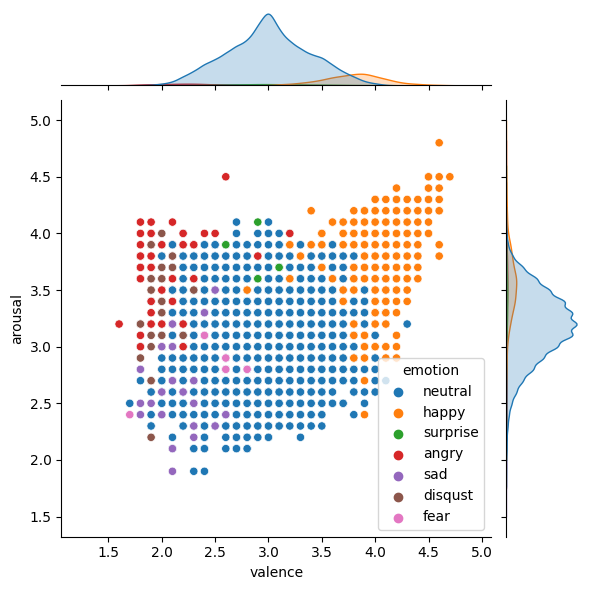

In [93]:
import seaborn as sns

sns.jointplot(x='valence', y='arousal', data=target_df, hue='emotion')

In [95]:
y_res

0         neutral
1         neutral
2         neutral
3         neutral
4         neutral
           ...   
77835    surprise
77836    surprise
77837    surprise
77838    surprise
77839    surprise
Name: emotion, Length: 77840, dtype: object

In [96]:
x_res['emotion'] = y_res

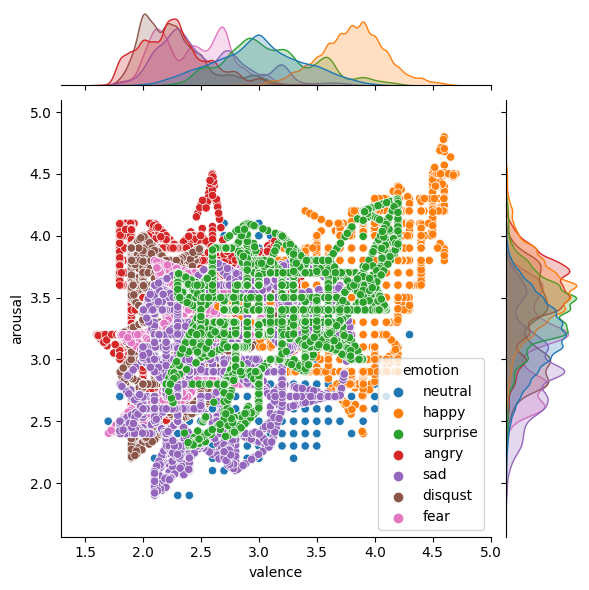

In [97]:
import seaborn as sns

sns.jointplot(x='valence', y='arousal', data=x_res, hue='emotion')

In [1]:
임베딩된 것을

텍스트  -> e1  - 감정

wave   ->  e2  - 감정

전제 : 텍스트 , 웨이브 감정에 대한 정보를 담고 있어서

SyntaxError: invalid syntax (4229473930.py, line 1)

In [ ]:
target_df

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[-0.06791500000000017, -0.110201, -0.025627999...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[0.006407000000000274, -0.021784000000000248, ...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3.0,"[0.07944700000000005, 0.05125599999999997, 0.0...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[0.0038439999999999586, -0.03331699999999982, ...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[0.1241910000000006, 0.09474499999999964, 0.03...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
13457,Sess40_script06_User079F_043,neutral,3.0,3.5,"[-0.023063999999999973, -0.02050200000000002, ...","[35.07, 35.07, 35.07, 35.07, 35.05, 35.05, 35....","[0.8125, 0.84375, 0.8125, 0.8125, 0.8125, 0.75..."
13458,Sess40_script06_User079F_044,neutral,2.9,3.1,"[-0.0064070000000000515, -0.005125000000000046...","[35.05, 35.05, 35.07, 35.07, 35.07, 35.07, 35....","[0.75, 0.75, 0.78125]"
13459,Sess40_script06_User079F_045,neutral,2.6,3.6,"[-0.007688000000000028, -0.002561999999999953,...","[35.05, 35.05, 35.05, 35.05, 35.05, 35.05, 35....","[0.8125, 0.8125, 0.828125, 0.828125, 0.796875,..."
13460,Sess40_script06_User079F_046,neutral,2.7,3.3,"[-0.0064069999999999405, -0.003844000000000069...","[35.05, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[0.75, 0.75, 0.765625]"


In [102]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
x_res, y_res = smt.fit_resample(target_df[['arousal', 'valence']], target_df['emotion'])


In [104]:
x_res['emotion'] = y_res

In [106]:
x_res['emotion'] = 'ne'

,arousal,valence,emotion
0,2.900000,3.400000,neutral
1,2.900000,3.100000,neutral
2,3.000000,3.100000,neutral
3,3.100000,3.700000,neutral
4,2.800000,3.800000,neutral
...,...,...,...
71099,3.600000,3.000000,surprise
71100,3.200000,2.900000,surprise
71101,3.475328,3.724672,surprise
71102,3.600000,3.295668,surprise


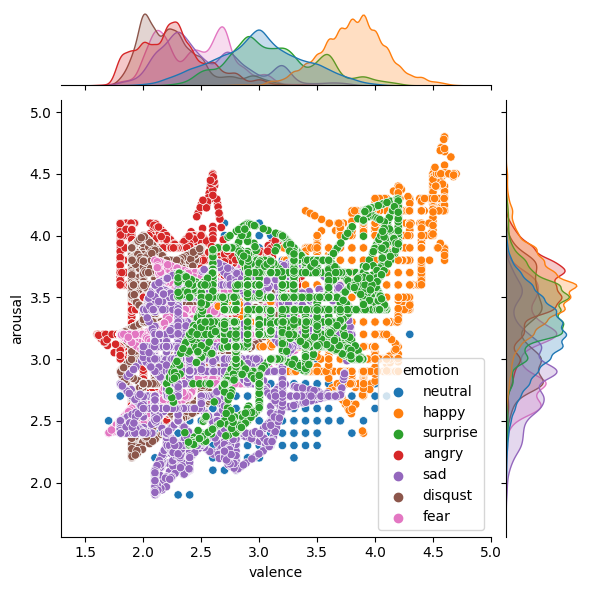

In [105]:
sns.jointplot(x='valence', y='arousal', data=x_res, hue='emotion')